## This notebook will hold any calculations to be used in the report that are not already included in my other analysis notebooks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Grab all my datasets
bond_pmts_without_totals = pd.read_pickle('../../data/mbs_data_pickled/bond_pmts.pkl')
delinq_stats_counts = pd.read_pickle('../../data/mbs_data_pickled/delinquency_stats.pkl')
delinq_stats_bals = pd.read_pickle('../../data/mbs_data_pickled/delinquency_stats_balances.pkl')
credit_ratings = pd.read_pickle('../../data/mbs_data_pickled/credit_ratings.pkl')
hist_pl_jan07_may13 = pd.read_pickle('../../data/mbs_data_pickled/hist_payoff_loss_jan07_may13.pkl')
hist_pl_with_totals = pd.read_pickle('../../data/mbs_data_pickled/hist_PL_with_totals.pkl')
prepayments = pd.read_pickle('../../data/mbs_data_pickled/prepayments.pkl')
realized_losses = pd.read_pickle('../../data/mbs_data_pickled/realized_losses.pkl')
remit_trust_with_swap = pd.read_pickle('../../data/mbs_data_pickled/remit_trust_with_swap.pkl')

## Cleaning and Refining (usually copied from other notebooks)

In [3]:
# From losses_vs_writedowns_aug18

# This function adds a Totals row to any permutation of the Bond Payments data
def create_total_row(df):
    columns_to_sum = [df.columns.to_list()[1]]
    remaining_cols = df.columns.to_list()[3:-1]
    columns_to_sum.extend(remaining_cols)
    # Iterate over the months, then for each column, tack on its sum for just that particular month
    for month in np.unique(bond_pmts_without_totals.index.get_level_values(0).values):
        for col in columns_to_sum:
            # If we're working with the full (original) dataset, we need to remove the non-core securities, like the CE and P tranches
            if 'I-CE' in df.index.get_level_values(1).values:
                bond_pmts_without_totals.loc[(month,'TOTAL'),col] = bond_pmts_without_totals.xs(month,level=0).drop(labels=['I-CE','I-P','I-R-1','I-R-2',                      'I-R-3','I-RX','II-CE','II-P','II-R-1','II-RX'])[col].sum()
            else:
                df.loc[(month,'TOTAL'),col] = df.xs(month,level=0)[col].sum()
    return df

In [4]:
# From losses_vs_writedowns_aug18

# Create separate dataframes holding just the senior securities and just the mezzanine securities
# This works by building up boolean arrays describing whether each row corresponds to a senior or mezzanine security (or neither),
# then slicing the rows of bond_pmts_without_totals based on that
# After that, we create TOTAL rows for each of the two dataframes
senior_slice = [False for row in range(len(bond_pmts_without_totals))]
mezz_slice = [False for row in range(len(bond_pmts_without_totals))]
for i in range(len(bond_pmts_without_totals.index.get_level_values(1).values)):
    security_name = bond_pmts_without_totals.index.get_level_values(1).values[i]
    if 'A' in security_name and 'TOTAL' not in security_name:
        senior_slice[i] = True
    else:
        senior_slice[i] = False
    if 'M' in security_name:
        mezz_slice[i] = True
    else:
        mezz_slice[i] = False

senior_only = bond_pmts_without_totals.loc[senior_slice]
senior_only = create_total_row(senior_only)
senior_only = senior_only.sort_index(level=0)
mezz_only = bond_pmts_without_totals.loc[mezz_slice]
mezz_only = create_total_row(mezz_only)
mezz_only = mezz_only.sort_index(level=0)

# Also add a TOTAL row for bond_pmts itself
bond_pmts = create_total_row(bond_pmts_without_totals)
bond_pmts = bond_pmts.sort_index(level=0)

<ipython-input-3-f8f2f2a3b794>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[(month,'TOTAL'),col] = df.xs(month,level=0)[col].sum()


In [5]:
# From credit_ratings

# Import credit ratings data and add it to the month-by-month dataframe
credit_ratings.drop(labels=['I-CE','I-P','II-CE','II-P'],level=1,inplace=True)
credit_ratings.drop(columns=['CUSIP'],inplace=True)
returns_with_ratings = pd.concat([credit_ratings,bond_pmts],axis=1)

# Add columns with numerical versions of Moody's ratings, with a higher number being better (Aaa = 21, C = 1)
returns_with_ratings['Moody\'s Numerical'] = returns_with_ratings['Moody\'s']
moodys_to_numbers = {'Aaa':21,'Aa1':20,'Aa2':19,'Aa3':18,'A1':17,'A2':16,'A3':15,'Baa1':14,'Baa2':13,'Baa3':12,'Ba1':11,'Ba2':10,'Ba3':9,'B1':8,'B2':7,'B3':6,'Caa1':5,'Caa2':4,'Caa3':3,'Ca':2,'C':1,'WR':1}
returns_with_ratings['Moody\'s Numerical'].replace(moodys_to_numbers,inplace=True)

# Change the order of the columns so the credit ratings are all the way on the right
cols = returns_with_ratings.columns.tolist()
cols.append("Moody\'s")
cols.append("S&P")
cols = cols[2:]
cols
returns_with_ratings = returns_with_ratings[cols]

## Calculations and Visualizations

In [6]:
# ORIGINAL FACE VALUE OF ALL CERTIFICATES AT DEAL'S INCEPTION
bond_pmts.xs('TOTAL',level=1)['Original Face Value'].head(1)

Date
2007-01-25    1096352000.0
Name: Original Face Value, dtype: object

In [7]:
# Date of first credit rating downgrades on the most junior securities (same for Group I and Group II)
returns_with_ratings.xs('I-M-9',level=1)['Moody\'s'].head(12)

Date
2007-01-25    Baa1
2007-02-26    Baa1
2007-03-26    Baa1
2007-04-25    Baa1
2007-05-25    Baa1
2007-06-25    Baa1
2007-07-25    Baa1
2007-08-27    Baa1
2007-09-25    Baa1
2007-10-25     Ba3
2007-11-26     Ba3
2007-12-26     Ba3
Name: Moody's, dtype: object

In [8]:
# Date when interest payments to the CE tranches stopped (shows that mortgage interest payments are no longer large enough to build up overcollateralization)
payments_to_CE = bond_pmts.xs('I-CE',level=1)
payments_to_CE[payments_to_CE['Interest Payment'] == 0].head()

,CUSIP,Original Face Value,NaN,Beginning Certificate Balance,Principal Payment,Principal Adjustment or Loss,Ending Certificate Balance,Interest Payment,Pass-Through Rate
Date,,,,,,,,,
2008-04-25,07389RBE5,322154468.27,N,256988270.64,0.0,0.0,254049920.56,0.0,N/A
2008-05-27,07389RBE5,322154468.27,N,254049920.56,0.0,0.0,251107287.09,0.0,N/A
2008-06-25,07389RBE5,322154468.27,N,251107287.09,0.0,0.0,245986629.22,0.0,N/A
2008-07-25,07389RBE5,322154468.27,N,245986629.22,0.0,0.0,243203589.08,0.0,N/A
2008-08-25,07389RBE5,322154468.27,N,243203589.08,0.0,0.0,238059092.38,0.0,N/A


In [9]:
# Compare writedowns to realized losses for all senior securities
for tranche in senior_only.xs('2007-01-25',level=0).index:
    print(tranche + " total realized losses: " + str(senior_only.xs(tranche,level=1)['Principal Adjustment or Loss'].sum()))
    print(tranche + " original certificate balance: " + str(senior_only.xs(tranche,level=1).loc['2007-01-25']['Original Face Value']))

I-A-1 total realized losses: 0.0
I-A-1 original certificate balance: 147515000.0
I-A-2 total realized losses: 0.0
I-A-2 original certificate balance: 67747000.0
I-A-3 total realized losses: 0.0
I-A-3 original certificate balance: 11213000.0
II-1A-1 total realized losses: 115255.02530514215
II-1A-1 original certificate balance: 176117000.0
II-1A-2 total realized losses: 15846980.388225047
II-1A-2 original certificate balance: 101081000.0
II-1A-3 total realized losses: 3705584.8121852595
II-1A-3 original certificate balance: 20339000.0
II-2A total realized losses: 13627370.09577187
II-2A original certificate balance: 201892000.0
II-3A total realized losses: 8094096.868512866
II-3A original certificate balance: 132221000.0
TOTAL total realized losses: 41389287.19000017
TOTAL original certificate balance: 858125000.0


In [10]:
# Compare writedowns to realized losses for all mezzanine securities
for tranche in mezz_only.xs('2007-01-25',level=0).index:
    print(tranche + " total realized losses: " + str(mezz_only.xs(tranche,level=1)['Principal Adjustment or Loss'].sum()))
    print(tranche + " original certificate balance: " + str(mezz_only.xs(tranche,level=1).loc['2007-01-25']['Original Face Value']))

I-M-1 total realized losses: 0.0
I-M-1 original certificate balance: 17235000.0
I-M-2 total realized losses: 15391687.919999998
I-M-2 original certificate balance: 19813000.0
I-M-3 total realized losses: 6121000.0
I-M-3 original certificate balance: 6121000.0
I-M-4 total realized losses: 7732000.0
I-M-4 original certificate balance: 7732000.0
I-M-5 total realized losses: 5799000.0
I-M-5 original certificate balance: 5799000.0
I-M-6 total realized losses: 4832000.0
I-M-6 original certificate balance: 4832000.0
I-M-7 total realized losses: 4832000.0
I-M-7 original certificate balance: 4832000.0
I-M-8 total realized losses: 3865000.0
I-M-8 original certificate balance: 3865000.0
I-M-9 total realized losses: 5315000.0
I-M-9 original certificate balance: 5315000.0
II-M-1 total realized losses: 43161000.00000001
II-M-1 original certificate balance: 43161000.0
II-M-2 total realized losses: 29465999.999999996
II-M-2 original certificate balance: 29466000.0
II-M-3 total realized losses: 1660100

In [11]:
# Current remaining principal balances across all securities
bond_pmts.xs('2020-03-25',level=0)['Ending Certificate Balance']

Class
I-A-1               0.0
I-A-2       20514053.28
I-A-3        11213000.0
I-CE        53919705.55
I-M-1        17235000.0
I-M-2        4421312.08
I-M-3               0.0
I-M-4               0.0
I-M-5               0.0
I-M-6               0.0
I-M-7               0.0
I-M-8               0.0
I-M-9               0.0
I-P               100.0
I-R-1               0.0
I-R-2               0.0
I-R-3               0.0
I-RX                0.0
II-1A-1           -0.01
II-1A-2     52560229.09
II-1A-3     16633415.19
II-2A       42792601.39
II-3A       17570003.05
II-CE      129764028.53
II-M-1              0.0
II-M-2              0.0
II-M-3              0.0
II-M-4              0.0
II-M-5              0.0
II-M-6              0.0
II-M-7              0.0
II-M-8              0.0
II-M-9              0.0
II-P              100.0
II-R-1              0.0
II-RX               0.0
TOTAL      182939614.07
Name: Ending Certificate Balance, dtype: object

In [12]:
# Interest rates at beginning vs. present
bond_pmts.xs('2020-03-25',level=0)

,CUSIP,Original Face Value,NaN,Beginning Certificate Balance,Principal Payment,Principal Adjustment or Loss,Ending Certificate Balance,Interest Payment,Pass-Through Rate
Class,,,,,,,,,
I-A-1,07389RAA4,147515000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.017368
I-A-2,07389RAB2,67747000.0,NaN,20927437.68,413384.4,0.0,20514053.28,30795.74,0.018267
I-A-3,07389RAC0,11213000.0,NaN,11213000.0,0.0,0.0,11213000.0,16861.78,0.018668
I-CE,07389RBE5,322154468.27,NaN,54170835.07,0.0,N/A,53919705.55,0.0,N/A
I-M-1,07389RAD8,17235000.0,NaN,17235000.0,0.0,0.0,17235000.0,27305.87,0.019668
I-M-2,07389RAE6,19813000.0,NaN,4421154.2,0.0,-157.88,4421312.08,7040.17,0.019768
I-M-3,07389RAF3,6121000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.020068
I-M-4,07389RAG1,7732000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.021167
I-M-5,07389RAH9,5799000.0,NaN,0.0,0.0,0.0,0.0,0.0,0.021368


In [13]:
# Calculate summary information about where the money went in this deal
def print_mtg_summary_info():
    prepayments_sum = prepayments.xs('Total',level=1).sum()
    remit_principal_sum = remit_trust_with_swap.xs('Total',level=1)['Remittance Principal'].sum()
    mtg_losses_sum = realized_losses.xs('Total',level=1).sum()
    mortgage_summary_table = pd.DataFrame(index=['Total prepayments','Total principal remitted to trust','Total realized losses on mortgage pool',\
                                                 'Size of mortgage pool at deal\'s Inception','Size of mortgage pool in March 2020'],columns=[''])

    mortgage_summary_table.loc["Total prepayments"] = prepayments_sum
    mortgage_summary_table.loc["Total principal remitted to trust"] = remit_principal_sum
    mortgage_summary_table.loc["Total realized losses on mortgage pool"] =  mtg_losses_sum
    mortgage_summary_table.loc["Size of mortgage pool at deal's inception"] = hist_pl_with_totals.xs('Total (All Loans)',level=1)['Ending Pool (Balance)'][0]
    mortgage_summary_table.loc["Size of mortgage pool in March 2020"] = 183683734.08
print_mtg_summary_info()

<ipython-input-14-95abd8af6cdb>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  prepayments_fig.show()


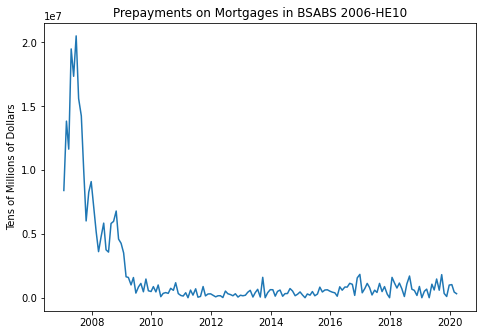

In [14]:
# Graph of prepayments over time
prepayments_fig = plt.figure()
prepayments_axes = prepayments_fig.add_axes([0,0,1,1])
prepayments_axes.plot(prepayments.xs('Total',level=1))
prepayments_axes.set_title('Prepayments on Mortgages in BSABS 2006-HE10')
prepayments_axes.set_ylabel("Tens of Millions of Dollars")
prepayments_fig.show()
prepayments_fig.savefig('../../figures/timeseries_prepayments.png',dpi=200,bbox_inches='tight')

In [15]:
# Following the work I did in losses_vs_writedowns_aug18, plot the cumulative loss rates (starting in March 2007) for fixed vs. ARM loans
# Compute the initial sizes of each loan type, as well as Fixed, ARM, Group I, Group II, and Total
# Trying this both for January 2007 (when the totals don't quite add up) and March 2007 (the first month when they do)
pool_size_after_jan07 = pd.DataFrame(hist_pl_with_totals.xs('2007-01-25',level=0)['Ending Pool (Balance)'])
pool_size_after_jan07.rename(columns={'Ending Pool (Balance)':'Ending Principal Balance (January 2007)'},inplace=True)
pool_size_after_mar07 = pd.DataFrame(hist_pl_with_totals.xs('2007-03-26',level=0)['Ending Pool (Balance)'])
pool_size_after_mar07.rename(columns={'Ending Pool (Balance)':'Ending Principal Balance (March 2007)'},inplace=True)

# Also make dataframes with the number of loans of each type, for possible hypothesis-testing purposes
num_of_loans_after_jan07 = pd.DataFrame(hist_pl_with_totals.xs('2007-01-25',level=0)['Ending Pool (Count)'])
num_of_loans_after_jan07.rename(columns={'Ending Pool (Count)':'Ending Number of Loans (January 2007)'},inplace=True)
num_of_loans_after_mar07 = pd.DataFrame(hist_pl_with_totals.xs('2007-03-26',level=0)['Ending Pool (Count)'])
num_of_loans_after_mar07.rename(columns={'Ending Pool (Count)':'Ending Number of Loans (March 2007)'},inplace=True)


# Compute the total realized losses from January 2007 to May 2013 for each loan type
loan_types = hist_pl_with_totals.xs('2007-01-25',level=0).index.get_level_values(0)
cumulative_mortgage_losses = pd.DataFrame(data=None,index=loan_types,columns=['Realized Losses from January 2007 to May 2013'])
for loan_type in loan_types.to_list():
    cumulative_mortgage_losses.loc[loan_type] = hist_pl_with_totals.xs(loan_type,level=1)['Realized Losses (Amount)'].sum()

# Calculate the fraction of principal that ended up being written off in each loan group
mortgage_loss_rates_jan07_base = pd.DataFrame(cumulative_mortgage_losses['Realized Losses from January 2007 to May 2013'] / \
pool_size_after_jan07['Ending Principal Balance (January 2007)'], columns=['Loss Rate (baseline = January 2007)'])
mortgage_loss_rates_mar07_base = pd.DataFrame(cumulative_mortgage_losses['Realized Losses from January 2007 to May 2013'] / \
pool_size_after_mar07['Ending Principal Balance (March 2007)'], columns=['Loss Rate (baseline = March 2007)'])

# Calculate each loan type's share of the initial principal balance
principals_as_pct_of_jan07_total = pool_size_after_jan07 / pool_size_after_jan07.loc['Total (All Loans)']['Ending Principal Balance (January 2007)']
principals_as_pct_of_jan07_total.rename(columns={'Ending Principal Balance (January 2007)':'January 2007 Principal Balance as Fraction of January 2007 Total'},inplace=True)
principals_as_pct_of_mar07_total = pool_size_after_mar07 / pool_size_after_mar07.loc['Total (All Loans)']['Ending Principal Balance (March 2007)']
principals_as_pct_of_mar07_total.rename(columns={'Ending Principal Balance (March 2007)':'March 2007 Principal Balance as Fraction of March 2007 Total'},inplace=True)

# Calculate each loan type's share of the total mortgage losses from January 2007 to May 2013
losses_as_pct_of_all_losses = pd.DataFrame(cumulative_mortgage_losses['Realized Losses from January 2007 to May 2013'] / \
cumulative_mortgage_losses.loc['Total (All Loans)']['Realized Losses from January 2007 to May 2013'])
losses_as_pct_of_all_losses.rename(columns={'Realized Losses from January 2007 to May 2013':'Realized Losses as Fraction of January 2007-May 2013 Total'},inplace=True)

# Prepare the final table, which I plan on including in my report
LOAN_TYPE_COMPARISON = pd.concat([num_of_loans_after_mar07,pool_size_after_mar07,mortgage_loss_rates_mar07_base,principals_as_pct_of_mar07_total,losses_as_pct_of_all_losses],axis=1)

In [16]:
LOAN_TYPE_COMPARISON.iloc[0:2]

,Ending Number of Loans (March 2007),Ending Principal Balance (March 2007),Loss Rate (baseline = March 2007),March 2007 Principal Balance as Fraction of March 2007 Total,Realized Losses as Fraction of January 2007-May 2013 Total
Group,,,,,
ARM,3405.0,8.471955e+08,0.319716,0.75985,0.772642
Fixed,1668.0,2.677550e+08,0.297675,0.24015,0.227358


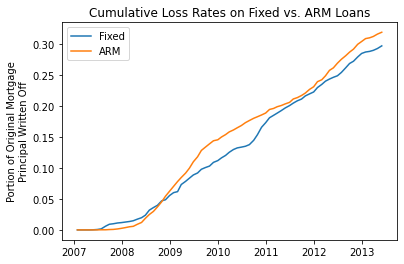

In [17]:
# Plot the cumulative loss rates on fixed vs. ARM loans
fixed_cumulative_losses = hist_pl_with_totals.xs('Fixed',level=1)['Realized Losses (Amount)'].cumsum()
arm_cumulative_losses = hist_pl_with_totals.xs('ARM',level=1)['Realized Losses (Amount)'].cumsum()

fixed_cumulative_loss_rate = fixed_cumulative_losses / pool_size_after_mar07.loc['Fixed']['Ending Principal Balance (March 2007)']
arm_cumulative_loss_rate = arm_cumulative_losses / pool_size_after_mar07.loc['ARM']['Ending Principal Balance (March 2007)']

plt.plot(fixed_cumulative_loss_rate,label='Fixed')
plt.plot(arm_cumulative_loss_rate,label='ARM')
plt.legend()
plt.ylabel('Portion of Original Mortgage\nPrincipal Written Off')
plt.title('Cumulative Loss Rates on Fixed vs. ARM Loans')
plt.savefig('../../figures/timeseries_cumulative_losses_fixed_vs_arm.png',dpi=200,bbox_inches='tight')

## Improve on a graph I made in losses_vs_writedowns_aug18 which compares total mortgage losses to total security writedowns

<ipython-input-18-81fbea9339b7>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  LminusW.show()


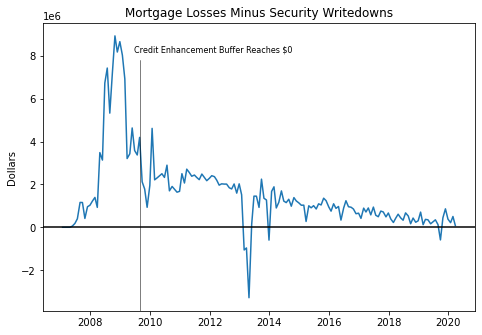

In [18]:
# When we consider just REALIZED LOSSES vs. security principal writedowns, we notice a large disparity after the CE tranche goes to zero, which means that the realized loss figure on its own isn't telling the whole story
# This graph is better than the version in losses_vs_writedowns_aug18 because that one only uses hist_pl_jan07_may13, which only has data through 2013 (the pre-2014 sections look to be the same, so it should be the same underlying data series)
LminusW = plt.figure()
LminusW_axes = LminusW.add_axes([0,0,1,1])
LminusW_axes.plot(realized_losses.xs('Total',level=1)['Realized Losses'] - bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'])
LminusW_axes.axvline(pd.Timestamp('2009-08-25'),color='black',lw=0.5,ymax=0.87)
LminusW_axes.axhline(0,color='black',lw=1.5)
LminusW_axes.text(0.21, 0.9, 'Credit Enhancement Buffer Reaches $0',transform=LminusW_axes.transAxes,fontsize=8)
LminusW_axes.set_title('Mortgage Losses Minus Security Writedowns')
LminusW_axes.set_ylabel('Dollars')
LminusW.show()

In [19]:
# Produce one graph regarding the results from the swap agreement, with 1mo LIBOR below for context
one_month_libor = pd.read_csv('../../data/external/one_month_libor.csv')
one_month_libor['DATE'] = pd.to_datetime(one_month_libor['DATE'])
one_month_libor.set_index('DATE',inplace=True)
one_month_libor.rename(columns={'USD1MTD156N':'One-Month USD LIBOR'},inplace=True)
one_month_libor = one_month_libor[one_month_libor['One-Month USD LIBOR'] != '.'].loc['2007-01-01':'2011-12-31']
one_month_libor['One-Month USD LIBOR'] = one_month_libor['One-Month USD LIBOR'].apply(lambda x:float(x))

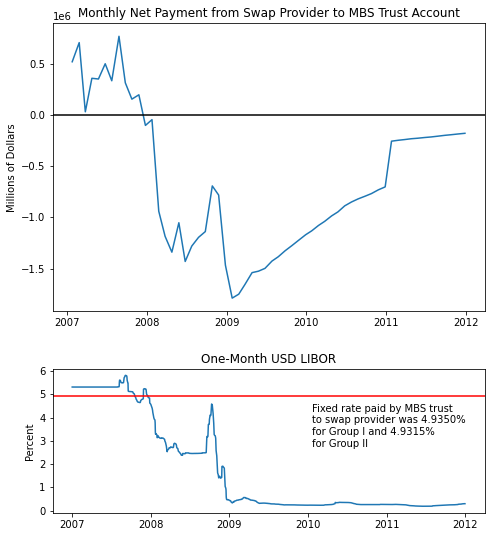

In [20]:
# Create a graph comparing total mortgage realized losses to total security writedowns
swap_graph = plt.figure()
swap_axes1 = swap_graph.add_axes([0,0.7,1,1])
net_swap_to_trust = remit_trust_with_swap.xs('Total',level=1)['Swap Due to Administrator'] - remit_trust_with_swap.xs('Total',level=1)['Swap Due to Provider']
net_swap_to_trust = net_swap_to_trust.loc['2007-01-01':'2011-12-31']
swap_axes1.plot(net_swap_to_trust)
swap_axes1.axhline(0,color='black',lw=1.5)
swap_axes1.set_ylabel('Millions of Dollars')
swap_axes1.set_title('Monthly Net Payment from Swap Provider to MBS Trust Account')

# Add in a side-by-side graph of the I-CE tranche to illustrate how credit enhancement is reduced by mortgage losses
swap_axes2 = swap_graph.add_axes([0,0,1,0.5])
swap_axes2.plot(one_month_libor.loc['2007-01-01':'2011-12-31']['One-Month USD LIBOR'])
swap_axes2.set_ylabel('Percent')
swap_axes2.axhline(4.935,color='red',lw=1.5)
swap_graph.text(0.6,0.23,'Fixed rate paid by MBS trust\nto swap provider was 4.9350%\nfor Group I and 4.9315%\nfor Group II')
swap_axes2.set_title('One-Month USD LIBOR')
swap_graph.savefig('../../figures/timeseries_swap_performance.png',dpi=200,bbox_inches='tight')

In [21]:
net_swap_to_trust.sum()

-39281171.0998

In [22]:
# Grab the "All-In Return" numbers that I calculated, to make graphs for my diversion on rates of return
all_in_return = pd.read_pickle('../../data/mbs_data_pickled/security_returns.pkl')
ratings_w_all_in_return = pd.merge(returns_with_ratings,all_in_return,how='inner',left_index=True,right_index=True)

In [23]:
def plot_all_in_return(securities_list):
    # Generate a plot of the all-in annualized monthly return for any one security
    # Then, we'll plot the monthly returns, as well as their annualized counterparts
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    axs = [ax1, ax2, ax3, ax4]
    for i in range(4):
        # First, we need to cut off the graph once the principal balance goes to zero, so that payments of a few cents                 # don't show up as crazy 1000% or -1000% returns
        zero_principal_months = bond_pmts.xs(securities_list[i],level=1)[bond_pmts.xs(securities_list[i],level=1)['Beginning Certificate Balance']==0]
        if len(zero_principal_months) == 0:
            zero_principal_start = '2020-04-01'
        else:
            zero_principal_start = str(zero_principal_months.index[0].date())
        legit_returns = ratings_w_all_in_return[ratings_w_all_in_return.index.get_level_values(0)<zero_principal_start]
        axs[i].plot(legit_returns.xs(securities_list[i],level=1)['Monthly All-In Return']*100,label='Monthly')
        axs[i].plot(legit_returns.xs(securities_list[i],level=1)['Annualized All-In Return']*100,label='Annualized')
        # Make the x-axis look a little better if it's going to be in the unit of months rather than years
        # (January 2013 is just a rough guess for this)
        if zero_principal_start < '2013-01-01':
            axs[i].xaxis.set_tick_params(rotation=45)
        axs[i].legend()
        axs[i].set_title(securities_list[i])
        axs[i].set_ylabel('Percent')
        fig.suptitle(r"\underline{``All-In'' Returns for Various Group I Securities}",y=0.94,fontsize='xx-large',usetex=True)
    return fig

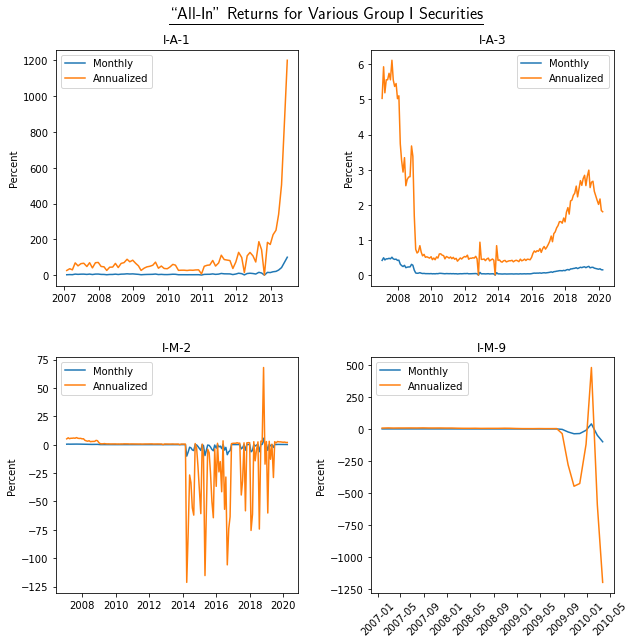

In [24]:
yields_figure = plot_all_in_return(['I-A-1','I-A-3','I-M-2','I-M-9'])

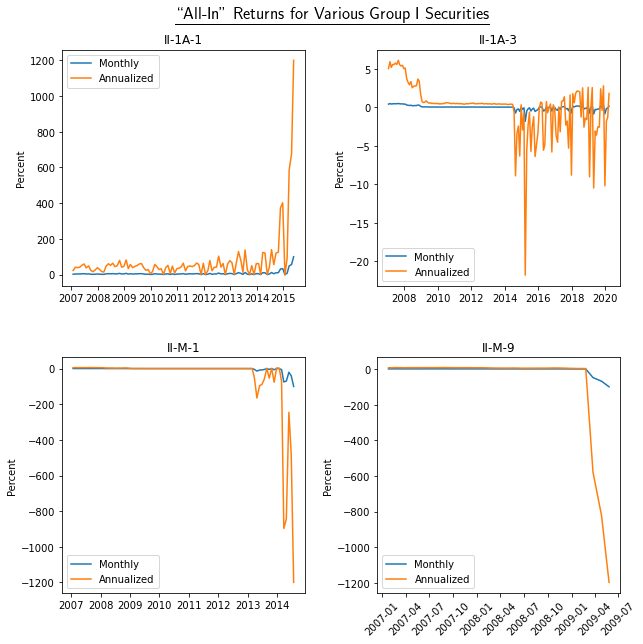

In [25]:
yields_figure_group_II = plot_all_in_return(['II-1A-1','II-1A-3','II-M-1','II-M-9'])

In [26]:
# Discussion of I-A-3 and II-1A-3 for Fed section (just printing out one number at a time)
returns_with_ratings.xs('II-1A-3',level=1)['Ending Certificate Balance'][-1]

16633415.19

In [27]:
# Find the overall security loss rate for the entire deal
bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'].cumsum() / bond_pmts.xs('TOTAL',level=1)['Original Face Value'][0]

Date
2007-01-25         0.0
2007-02-26         0.0
2007-03-26         0.0
2007-04-25         0.0
2007-05-25         0.0
                ...   
2019-11-25    0.233951
2019-12-26    0.234788
2020-01-27    0.235049
2020-02-25     0.23529
2020-03-25    0.235289
Name: Principal Adjustment or Loss, Length: 159, dtype: object

In [28]:
bond_pmts.xs('I-A-3',level=1)['Pass-Through Rate']

Date
2007-01-25      0.0559
2007-02-26      0.0556
2007-03-26      0.0556
2007-04-25      0.0556
2007-05-25      0.0556
                ...   
2019-11-25    0.020628
2019-12-26     0.01948
2020-01-27     0.02032
2020-02-25    0.019009
2020-03-25    0.018668
Name: Pass-Through Rate, Length: 159, dtype: object

In [29]:
realized_losses.xs('Total',level=1).sum() / 1152179900
# The number on the right is the original aggregate principal balance of the mortgage pool as of the deal's cut-off date, as expressed on page S-5 of the prospectus
# So, the FINAL loss rate for mortgage principal was 44.2%

Realized Losses    0.442629
dtype: float64

In [30]:
bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'].sum() / bond_pmts.xs('TOTAL',level=1)['Original Face Value'][0]
# This is the FINAL loss rate for the securities

0.23528937340379752

In [31]:
1 - (bond_pmts.xs('TOTAL',level=1)['Principal Adjustment or Loss'].sum() / realized_losses.xs('Total',level=1).sum())
# This is the FINAL fraction of mortgage writedowns that investors were protected from by the credit enhancement mechanisms

Realized Losses    0.494185
dtype: float64

IMPORTANT COMMENT: the reason why the securities' loss rate isn't exactly 0.494185 * the mortgages' loss rate is the difference in denominators -- the mortgages have a larger initial principal balance than the securities (meaning a larger denominator), so each $1 of losses makes a smaller contribution to the mortgages' loss rate than to the securities' loss rate

In [32]:
# Final loan type comparison table for Appendix B
LOAN_TYPE_COMPARISON['Ending Principal Balance (March 2007)'].apply(lambda x: str(x))

Group
ARM                                                 847195525.39
Fixed                                          267754983.5099999
Group I                                       313081395.59000003
Group I Loans 228 ARM                               248404264.43
Group I Loans 327 ARM                                 8230610.66
Group I Loans Fixed 1st Lien                         50617126.76
Group I Loans Fixed 2nd Lien                          5829393.74
Group II                                       801869113.3099997
Group II Loans Subgroup I 228 ARM                   253703351.32
Group II Loans Subgroup I 327 ARM                    28497466.32
Group II Loans Subgroup I Fixed 1st Lien             66556173.59
Group II Loans Subgroup I Fixed 2nd Lien             29495741.19
Group II Loans Subgroup II 228 ARM                  161584501.63
Group II Loans Subgroup II 327 ARM                   21965710.18
Group II Loans Subgroup II Fixed 1st Lien       69912843.4499999
Group II Loans Subg

## List of all the datasets I'm using in this notebook

In [33]:
# View all of my datasets

bond_pmts
# delinq_stats_counts
# delinq_stats_bals
# credit_ratings
# hist_pl_jan07_may13
# hist_pl_with_totals
# prepayments
# realized_losses
# remit_trust_with_swap
# senior_only
# mezz_only
# returns_with_ratings
# all_in_return
# ratings_w_all_in_return

CUSIP Original Face Value  NaN  \
Date       Class                                        
2007-01-25 I-A-1   07389RAA4         147515000.0        
           I-A-2   07389RAB2          67747000.0        
           I-A-3   07389RAC0          11213000.0        
           I-CE    07389RBE5        322154468.27   N    
           I-M-1   07389RAD8          17235000.0        
...                      ...                 ...  ...   
2020-03-25 II-M-9  07389RBB1          11205000.0  NaN   
           II-P    07389RBN5               100.0  NaN   
           II-R-1  07389RBL9                 0.0  NaN   
           II-RX   07389RBM7                 0.0  NaN   
           TOTAL         NaN        1096352000.0  NaN   

                  Beginning Certificate Balance Principal Payment  \
Date       Class                                                    
2007-01-25 I-A-1                    147515000.0        2576941.66   
           I-A-2                     67747000.0               0.0   
           I-A-3                     11213000.0               0.0   
           I-CE                    322154468.27               0.0   
           I-M-1                     17235000.0               0.0   
...                                         ...               ...   
2020-03-25 II-M-9                           0.0               0.0   
           II-P                           100.0               0.0   
           II-R-1                           0.0               0.0   
           II-RX                            0.0               0.0   
           TOTAL                   184175038.32        1235837.52   

                  Principal Adjustment or Loss Ending Certificate Balance  \
Date       Class                                                            
2007-01-25 I-A-1                           0.0               144938058.34   
           I-A-2                           0.0                 67747000.0   
           I-A-3                           0.0                 11213000.0   
           I-CE                            0.0               319576712.61   
           I-M-1                           0.0                 17235000.0   
...                                        ...                        ...   
2020-03-25 II-M-9                          0.0                        0.0   
           II-P                            N/A                      100.0   
           II-R-1                          N/A                        0.0   
           II-RX                           N/A                        0.0   
           TOTAL                       -413.27               182939614.07   

                  Interest Payment Pass-Through Rate  
Date       Class                                      
2007-01-25 I-A-1         604073.92            0.0546  
           I-A-2         281996.89            0.0555  
           I-A-3           47010.5            0.0559  
           I-CE         1089810.23               N/A  
           I-M-1          73550.36            0.0569  
...                            ...               ...  
2020-03-25 II-M-9              0.0          0.038767  
           II-P                0.0               0.0  
           II-R-1              0.0               0.0  
           II-RX               0.0               0.0  
           TOTAL         270175.52               NaN  

[5883 rows x 9 columns]